### Load eval

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

import seaborn as sns
sns.set()

def peak_index(group, x_index, y_index):
    max_x, max_y = 0, -1

    for id_label, _ in group.iterrows():
        try:
            if group.at[id_label , y_index] is not None:
                if isinstance(group.at[id_label , y_index], pd.core.series.Series):
                    if len(group.at[id_label , y_index]) > 1:
                        new_v = group.at[id_label , y_index].iloc[0].item()
                    if len(group.at[id_label , y_index]) == 0:
                        continue
                else:
                    new_v = group.at[id_label , y_index]
#                 print(new_v)
                if new_v > max_y:
                    max_y = new_v
                    max_x = group.at[id_label , x_index]
        except Exception as e:
            print(group.at[id_label , y_index])
            print(type(group.at[id_label , y_index]))
            print(isinstance(group.at[id_label , y_index], pd.core.series.Series))
            print(len(group.at[id_label , y_index]))
            raise e
            
    return max_x, max_y

def plot_testing_curve(df, y_index, title=''):
    peak_box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
    
    fig, ax = plt.subplots(figsize=(16,5))
    for key, grp in df.groupby(['exp_name']): 
        ax = grp.plot(ax=ax, title=title, kind='line', x='step', y=y_index, label=key, style='-o', markersize=8.0, linewidth=4)
        peak_x, peak_y = peak_index(grp, x_index='step', y_index=y_index)
        variance = grp[y_index].var()
        ax.annotate('%s peak=%.3f (@step=%d)' % (key, peak_y, peak_x), xy=(peak_x, peak_y), textcoords='data', size=8, bbox=peak_box_props)
#         display(grp)
#         break

    plt.legend(loc='best')
    plt.show()


def best_testscores_by_dev(df, dev_dataset, test_dataset, anchor_metric_name, ignore_duplicate=True):
    dev_df = df.loc[df['test_dataset'] == dev_dataset]
    test_df = df.loc[df['test_dataset'] == test_dataset]
    dev_df = dev_df.sort_values(by=anchor_metric_name, ascending=False)
    test_df = test_df.sort_values(by=anchor_metric_name, ascending=False)

    if len(dev_df) == 0: 
        print('No valid score found! Return None')
        return None

    if len(test_df) == 0: 
        print('No test score found! Return None')
        return None

    dev_row = dev_df.iloc[0].to_frame().transpose()
    
    test_row = None
    for idx, dev_row in dev_df.iterrows():
        best_step = dev_row.step
        test_row = test_df.loc[test_df.step == best_step]
        if len(test_row) == 1:
            dev_row = dev_row.to_frame().transpose()
            test_row = test_row.iloc[0].to_frame().transpose()
            break
        elif len(test_row) > 1:
            print('Found multiple rows (%d rows): exp=%s' % (
                len(test_row), exp_name))
            display(test_row)
            if ignore_duplicate:
                dev_row = dev_row.to_frame().transpose()
                test_row = test_row.iloc[0].to_frame().transpose()
                break
            else:
                raise ValueError()
#     display(dev_row[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
#     display(test_row[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    return test_row

### Load all .eval

In [2]:
# fulldata
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/cross_domain_exps/kp_o2s_fulldata_devbest/report'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

    print(len(all_eval_df))
print(all_eval_df.test_dataset.unique())
print(all_eval_df.exp_name.unique())
print(all_eval_df.test_dataset.unique())

10
20
30
40
50
60
70
80
90
100
['stackex_test' 'openkp_valid2k_test' 'duc_test' 'kptimes_test'
 'openkp_test' 'kptimes_valid2k_test' 'stackex_valid2k_test'
 'jptimes_test' 'kp20k_valid2k_test' 'kp20k_test']
['bartFT_presabs_openkp_100k' 'bartFT_presabs_openkp_100k_rerun'
 'bartFT_presabs_kp20k_100k_rerun' 'transformer_presabs_stackex'
 'bartFT_presabs_kptimes_100k_rerun' 'transformer_presabs_openkp'
 'transformer_presabs_kptimes' 'bartFT_presabs_kp20k_100k'
 'bartFT_presabs_stackex_100k_rerun' 'transformer_presabs_kp20k']
['stackex_test' 'openkp_valid2k_test' 'duc_test' 'kptimes_test'
 'openkp_test' 'kptimes_valid2k_test' 'stackex_valid2k_test'
 'jptimes_test' 'kp20k_valid2k_test' 'kp20k_test']


### Plot Heatmap for Transfer Across Domains

In [11]:
short2long = {
# 'BART-KP20k': 'bartFT_presabs_kp20k_100k_rerun',
# 'BART-OpenKP': 'bartFT_presabs_openkp_100k_rerun',
# 'BART-KPTimes': 'bartFT_presabs_kptimes_100k_rerun',
# 'BART-StackEx': 'bartFT_presabs_stackex_100k_rerun',

'TF-KP20k': 'transformer_presabs_kp20k',
'TF-OpenKP': 'transformer_presabs_openkp',
'TF-KPTimes': 'transformer_presabs_kptimes',
'TF-StackEx': 'transformer_presabs_stackex'
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp_valid2k_test', 'openkp_test'),
                  ('kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex_valid2k_test', 'stackex_test')]
testname_map = {
    'kp20k_test': 'KP20k', 
    'openkp_test': 'OpenKP', 
    'kptimes_test': 'KPTimes', 
    'stackex_test': 'StackEx', 
}

anchor_metric_name = 'all_exact_f_score@k'
train_test_scores = {}

for short_name, exp_name in short2long.items():
    exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
    exp_grp = exp_grp.sort_values(by='step', ascending=True)

    print(exp_name, len(exp_grp))
    train_test_scores[long2short[exp_name]] = {}
    
#     display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
    for dev_dataset, test_dataset in dev_test_pairs:
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        train_test_scores[long2short[exp_name]][testname_map[test_dataset]] = best_test_row[anchor_metric_name].values[0]
        
print(train_test_scores)
        
# avg_bar_values = {'Beam': [], 'R@50': [], 'model': []}
# kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
# for k, v in bar_values.items():
#     _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
#     avg_bar_values['Beam'].append(int(k))
#     avg_bar_values['R@50'].append(np.mean(_v))
#     avg_bar_values['model'].append('TF')


transformer_presabs_kp20k 10
transformer_presabs_openkp 10
transformer_presabs_kptimes 10
transformer_presabs_stackex 10
{'TF-KP20k': {'KP20k': 0.2950610537355346, 'OpenKP': 0.0331670194536841, 'KPTimes': 0.0238392735042735, 'StackEx': 0.1173166666666666}, 'TF-OpenKP': {'KP20k': 0.0301053071419493, 'OpenKP': 0.183441689345832, 'KPTimes': 0.0518436904761904, 'StackEx': 0.0521833333333333}, 'TF-KPTimes': {'KP20k': 0.0092436171050924, 'OpenKP': 0.0286765447031549, 'KPTimes': 0.5025780158730159, 'StackEx': 0.0138125}, 'TF-StackEx': {'KP20k': 0.0405206069849953, 'OpenKP': 0.0104576151597621, 'KPTimes': 0.0042925793650793, 'StackEx': 0.5023770833333333}}


,KP20k,OpenKP,KPTimes,StackEx
TF-KP20k,29.506105,3.316702,2.383927,11.731667
TF-OpenKP,3.010531,18.344169,5.184369,5.218333
TF-KPTimes,0.924362,2.867654,50.257802,1.381250
TF-StackEx,4.052061,1.045762,0.429258,50.237708


<AxesSubplot:>

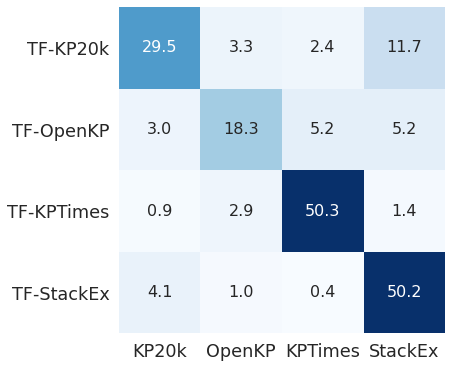

In [13]:
train_test_matrix = pd.DataFrame(data=train_test_scores)
train_test_matrix = train_test_matrix.transpose() * 100.0
display(train_test_matrix)

# sns.set_context("paper", rc={"font.size": 14,
#                              "axes.titlesize": 24,
#                              "axes.labelsize": 14,
#                              "xtick.labelsize": 14,
#                              "ytick.labelsize": 14,
#                              "legend.fontsize": 14})

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(train_test_matrix, 
            cmap='Blues',
#             cmap='Reds',
#             cmap='coolwarm', 
            annot=True, fmt=".1f", 
            annot_kws={'size':16},
            cbar=False,
            square=True,
#             xticklabels=False,
#             yticklabels=False
           )

bartFT_presabs_kp20k_100k_rerun 10
bartFT_presabs_openkp_100k_rerun 10
bartFT_presabs_kptimes_100k_rerun 10
bartFT_presabs_stackex_100k_rerun 10
{'BART-KP20k': {'KP20k': 0.3247736233549484, 'OpenKP': 0.1901093639754056, 'KPTimes': 0.1131522723475355, 'StackEx': 0.23204375}, 'BART-OpenKP': {'KP20k': 0.194497983279298, 'OpenKP': 0.4270512045156738, 'KPTimes': 0.1766549603174603, 'StackEx': 0.1869166666666666}, 'BART-KPTimes': {'KP20k': 0.0251171736853645, 'OpenKP': 0.1116167725027719, 'KPTimes': 0.6450049603174604, 'StackEx': 0.1177729166666666}, 'BART-StackEx': {'KP20k': 0.0609741117857706, 'OpenKP': 0.0411601653059167, 'KPTimes': 0.0713909126984126, 'StackEx': 0.5696531250000001}}


,KP20k,OpenKP,KPTimes,StackEx
BART-KP20k,32.477362,19.010936,11.315227,23.204375
BART-OpenKP,19.449798,42.705120,17.665496,18.691667
BART-KPTimes,2.511717,11.161677,64.500496,11.777292
BART-StackEx,6.097411,4.116017,7.139091,56.965313


<AxesSubplot:>

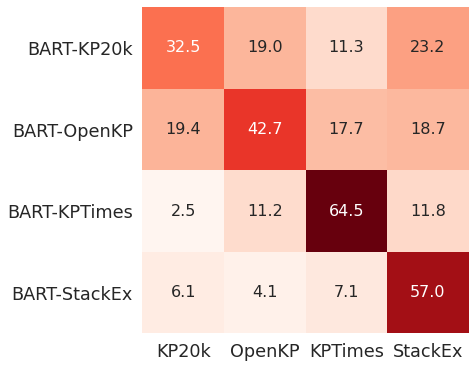

In [14]:
short2long = {
'BART-KP20k': 'bartFT_presabs_kp20k_100k_rerun',
'BART-OpenKP': 'bartFT_presabs_openkp_100k_rerun',
'BART-KPTimes': 'bartFT_presabs_kptimes_100k_rerun',
'BART-StackEx': 'bartFT_presabs_stackex_100k_rerun',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp_valid2k_test', 'openkp_test'),
                  ('kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex_valid2k_test', 'stackex_test')]
testname_map = {
    'kp20k_test': 'KP20k', 
    'openkp_test': 'OpenKP', 
    'kptimes_test': 'KPTimes', 
    'stackex_test': 'StackEx', 
}

anchor_metric_name = 'all_exact_f_score@k'
train_test_scores = {}

for short_name, exp_name in short2long.items():
    exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
    exp_grp = exp_grp.sort_values(by='step', ascending=True)

    print(exp_name, len(exp_grp))
    train_test_scores[long2short[exp_name]] = {}
    
#     display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
    for dev_dataset, test_dataset in dev_test_pairs:
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        train_test_scores[long2short[exp_name]][testname_map[test_dataset]] = best_test_row[anchor_metric_name].values[0]
        
print(train_test_scores)

train_test_matrix = pd.DataFrame(data=train_test_scores)
train_test_matrix = train_test_matrix.transpose() * 100.0
display(train_test_matrix)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(train_test_matrix, 
#             cmap='Blues',
            cmap='Reds',
#             cmap='coolwarm', 
            annot=True, fmt=".1f", 
            annot_kws={'size':16},
            cbar=False,
            square=True,
#             xticklabels=False,
#             yticklabels=False
           )

### TF fewshot results

In [37]:
# TF-fewshot
report_dirs = ['/zfs1/pbrusilovsky/rum20/kp/transfer_exps/tf_FT_devbest/report',
               '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/tf_DAFT_devbest/report',
               '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/tf_PTFT_devbest/report',
               '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/tf_PTDAFT_devbest/report',
              ]
pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None

for report_dir in report_dirs:
    for fname in os.listdir(report_dir):
        if not fname.endswith('.split_nopunc.csv'): continue
        df = pd.read_csv(os.path.join(report_dir, fname))
        df = df.loc[df.pred_name == pred_name]
        df = df.sort_values(by='step', ascending=True)

        all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [38]:
short2long = {
'FT-KP20k-100': 'transformer-kp20k-fewshot100-lr3e4-step2k',
'FT-KP20k-1k': 'transformer-kp20k-fewshot1k-lr3e4-step4k',
'FT-KP20k-10k': 'transformer-kp20k-fewshot10k-lr3e4-step8k',
'FT-OpenKP-100': 'transformer-openkp-fewshot100-lr3e4-step2k',
'FT-OpenKP-1k': 'transformer-openkp-fewshot1k-lr3e4-step4k',
'FT-OpenKP-10k': 'transformer-openkp-fewshot10k-lr3e4-step8k', 
'FT-KPTimes-100': 'transformer-kptimes-fewshot100-lr3e4-step2k',
'FT-KPTimes-1k': 'transformer-kptimes-fewshot1k-lr3e4-step4k',
'FT-KPTimes-10k': 'transformer-kptimes-fewshot10k-lr3e4-step8k',
'FT-StackEx-100': 'transformer-stackex-fewshot100-lr3e4-step2k',
'FT-StackEx-1k': 'transformer-stackex-fewshot1k-lr3e4-step4k',
'FT-StackEx-10k': 'transformer-stackex-fewshot10k-lr3e4-step8k',

'DA+FT-KP20k-100': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot100_step1k_lr1e5',
'DA+FT-KP20k-1k': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot1k_step2k_lr1e5',
'DA+FT-KP20k-10k': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot10k_step4k_lr1e5',
'DA+FT-OpenKP-100': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot100_step1k_lr1e5',
'DA+FT-OpenKP-1k': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot1k_step2k_lr1e5',
'DA+FT-OpenKP-10k': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot10k_step4k_lr1e5',
'DA+FT-KPTimes-100': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot100_step1k_lr1e5',
'DA+FT-KPTimes-1k': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot1k_step2k_lr1e5',
'DA+FT-KPTimes-10k': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot10k_step4k_lr1e5',
'DA+FT-StackEx-100': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot100_step1k_lr1e5',
'DA+FT-StackEx-1k': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot1k_step2k_lr1e5',
'DA+FT-StackEx-10k': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot10k_step4k_lr1e5',

'PT+FT-KP20k-100': 'transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-KP20k-1k': 'transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-KP20k-10k': 'transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'PT+FT-OpenKP-100': 'transformer-openkp-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-OpenKP-1k': 'transformer-openkp-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-OpenKP-10k': 'transformer-openkp-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'PT+FT-KPTimes-100': 'transformer-kptimes-PT_step200k-FT_fewshot100_step2k_lr1e5',
'PT+FT-KPTimes-1k': 'transformer-kptimes-PT_step200k-FT_fewshot1k_step4k_lr1e5',
'PT+FT-KPTimes-10k': 'transformer-kptimes-PT_step200k-FT_fewshot10k_step8k_lr1e5',
'PT+FT-StackEx-100': 'transformer-stackex-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-StackEx-1k': 'transformer-stackex-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-StackEx-10k': 'transformer-stackex-PT_step200k-FT_fewshot10k_step4k_lr1e5',

'PT+DA+FT-KP20k-100': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot100_step1k_lr1e5',
'PT+DA+FT-KP20k-1k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot1k_step2k_lr1e5',
'PT+DA+FT-KP20k-10k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot10k_step4k_lr1e5',
'PT+DA+FT-OpenKP-100': 'transformer-PTDA_tlrs55-FT_openkp_fewshot100_step1k_lr1e5',
'PT+DA+FT-OpenKP-1k': 'transformer-PTDA_tlrs55-FT_openkp_fewshot1k_step2k_lr1e5',
'PT+DA+FT-OpenKP-10k': 'transformer-PTDA_tlrs55-FT_openkp_fewshot10k_step4k_lr1e5',
'PT+DA+FT-KPTimes-100': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot100_step1k_lr1e5',
'PT+DA+FT-KPTimes-1k': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot1k_step2k_lr1e5',
'PT+DA+FT-KPTimes-10k': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot10k_step4k_lr1e5',
'PT+DA+FT-StackEx-100': 'transformer-PTDA_tlrs55-FT_stackex_fewshot100_step1k_lr1e5',
'PT+DA+FT-StackEx-1k': 'transformer-PTDA_tlrs55-FT_stackex_fewshot1k_step2k_lr1e5',
'PT+DA+FT-StackEx-10k': 'transformer-PTDA_tlrs55-FT_stackex_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0 if best_test_row is not None and len(best_test_row) > 0 else 0.0
        })
        
# print(train_test_scores)

transformer-kp20k-fewshot100-lr3e4-step2k 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot1k-lr3e4-step4k 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-fewshot10k-lr3e4-step8k 7 kp20k_valid2k_test kp20k_test
transformer-DA_tlrs55_40k-FT_kp20k_fewshot100_step1k_lr1e5 3 kp20k_valid2k_test kp20k_test
transformer-DA_tlrs55_40k-FT_kp20k_fewshot1k_step2k_lr1e5 3 kp20k_valid2k_test kp20k_test
transformer-DA_tlrs55_40k-FT_kp20k_fewshot10k_step4k_lr1e5 3 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5 7 kp20k_valid2k_test kp20k_test
transformer-PTDA_tlrs55-FT_kp20k_fewshot100_step1k_lr1e5 3 kp20k_valid2k_test kp20k_test
transformer-PTDA_tlrs55-FT_kp20k_fewshot1k_step2k_lr1e5 3 kp20k_valid2k_test kp20k_test
transformer-PTDA_tlrs55-FT_kp20k_fewshot10k_step4k_lr1e5 3 kp20k

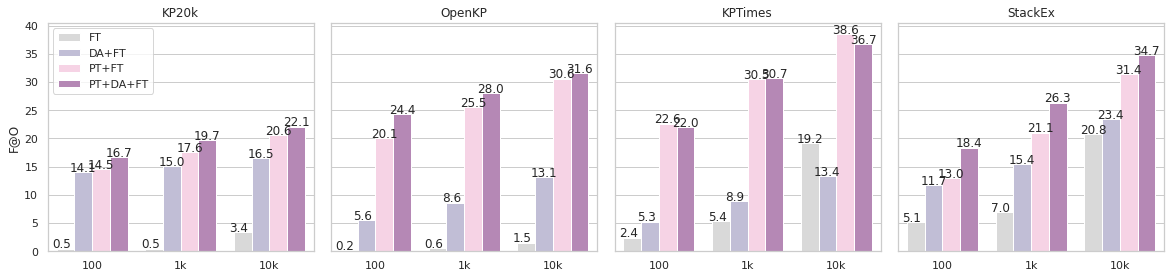

In [39]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[8], _set3[2], _set3[7], _set3[9]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() - 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("F@O")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)


#### Present

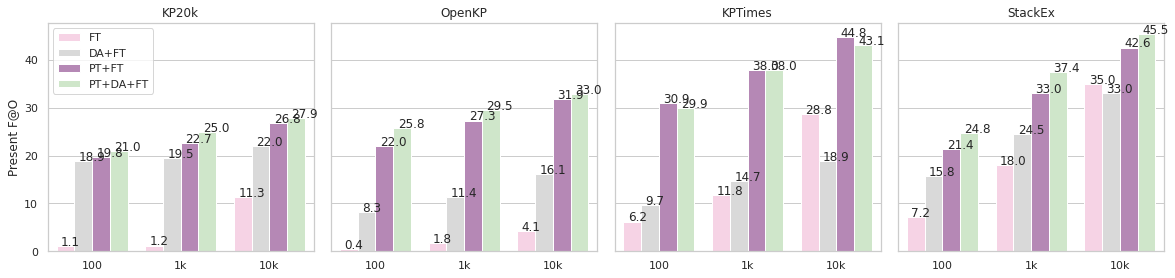

In [43]:
short2long = {
'FT-KP20k-100': 'transformer-kp20k-fewshot100-lr3e4-step2k',
'FT-KP20k-1k': 'transformer-kp20k-fewshot1k-lr3e4-step4k',
'FT-KP20k-10k': 'transformer-kp20k-fewshot10k-lr3e4-step8k',
'FT-OpenKP-100': 'transformer-openkp-fewshot100-lr3e4-step2k',
'FT-OpenKP-1k': 'transformer-openkp-fewshot1k-lr3e4-step4k',
'FT-OpenKP-10k': 'transformer-openkp-fewshot10k-lr3e4-step8k', 
'FT-KPTimes-100': 'transformer-kptimes-fewshot100-lr3e4-step2k',
'FT-KPTimes-1k': 'transformer-kptimes-fewshot1k-lr3e4-step4k',
'FT-KPTimes-10k': 'transformer-kptimes-fewshot10k-lr3e4-step8k',
'FT-StackEx-100': 'transformer-stackex-fewshot100-lr3e4-step2k',
'FT-StackEx-1k': 'transformer-stackex-fewshot1k-lr3e4-step4k',
'FT-StackEx-10k': 'transformer-stackex-fewshot10k-lr3e4-step8k',

'DA+FT-KP20k-100': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot100_step1k_lr1e5',
'DA+FT-KP20k-1k': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot1k_step2k_lr1e5',
'DA+FT-KP20k-10k': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot10k_step4k_lr1e5',
'DA+FT-OpenKP-100': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot100_step1k_lr1e5',
'DA+FT-OpenKP-1k': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot1k_step2k_lr1e5',
'DA+FT-OpenKP-10k': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot10k_step4k_lr1e5',
'DA+FT-KPTimes-100': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot100_step1k_lr1e5',
'DA+FT-KPTimes-1k': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot1k_step2k_lr1e5',
'DA+FT-KPTimes-10k': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot10k_step4k_lr1e5',
'DA+FT-StackEx-100': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot100_step1k_lr1e5',
'DA+FT-StackEx-1k': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot1k_step2k_lr1e5',
'DA+FT-StackEx-10k': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot10k_step4k_lr1e5',

'PT+FT-KP20k-100': 'transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-KP20k-1k': 'transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-KP20k-10k': 'transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'PT+FT-OpenKP-100': 'transformer-openkp-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-OpenKP-1k': 'transformer-openkp-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-OpenKP-10k': 'transformer-openkp-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'PT+FT-KPTimes-100': 'transformer-kptimes-PT_step200k-FT_fewshot100_step2k_lr1e5',
'PT+FT-KPTimes-1k': 'transformer-kptimes-PT_step200k-FT_fewshot1k_step4k_lr1e5',
'PT+FT-KPTimes-10k': 'transformer-kptimes-PT_step200k-FT_fewshot10k_step8k_lr1e5',
'PT+FT-StackEx-100': 'transformer-stackex-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-StackEx-1k': 'transformer-stackex-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-StackEx-10k': 'transformer-stackex-PT_step200k-FT_fewshot10k_step4k_lr1e5',

'PT+DA+FT-KP20k-100': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot100_step1k_lr1e5',
'PT+DA+FT-KP20k-1k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot1k_step2k_lr1e5',
'PT+DA+FT-KP20k-10k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot10k_step4k_lr1e5',
'PT+DA+FT-OpenKP-100': 'transformer-PTDA_tlrs55-FT_openkp_fewshot100_step1k_lr1e5',
'PT+DA+FT-OpenKP-1k': 'transformer-PTDA_tlrs55-FT_openkp_fewshot1k_step2k_lr1e5',
'PT+DA+FT-OpenKP-10k': 'transformer-PTDA_tlrs55-FT_openkp_fewshot10k_step4k_lr1e5',
'PT+DA+FT-KPTimes-100': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot100_step1k_lr1e5',
'PT+DA+FT-KPTimes-1k': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot1k_step2k_lr1e5',
'PT+DA+FT-KPTimes-10k': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot10k_step4k_lr1e5',
'PT+DA+FT-StackEx-100': 'transformer-PTDA_tlrs55-FT_stackex_fewshot100_step1k_lr1e5',
'PT+DA+FT-StackEx-1k': 'transformer-PTDA_tlrs55-FT_stackex_fewshot1k_step2k_lr1e5',
'PT+DA+FT-StackEx-10k': 'transformer-PTDA_tlrs55-FT_stackex_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'present_exact_f_score@k'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=_set3[7:] + [_set3[2], _set3[3]]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Present F@O")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

#### Absent

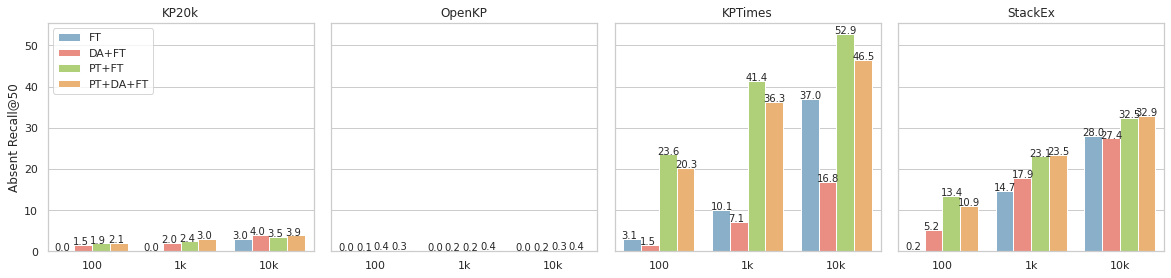

In [53]:
short2long = {
'FT-KP20k-100': 'transformer-kp20k-fewshot100-lr3e4-step2k',
'FT-KP20k-1k': 'transformer-kp20k-fewshot1k-lr3e4-step4k',
'FT-KP20k-10k': 'transformer-kp20k-fewshot10k-lr3e4-step8k',
'FT-OpenKP-100': 'transformer-openkp-fewshot100-lr3e4-step2k',
'FT-OpenKP-1k': 'transformer-openkp-fewshot1k-lr3e4-step4k',
'FT-OpenKP-10k': 'transformer-openkp-fewshot10k-lr3e4-step8k', 
'FT-KPTimes-100': 'transformer-kptimes-fewshot100-lr3e4-step2k',
'FT-KPTimes-1k': 'transformer-kptimes-fewshot1k-lr3e4-step4k',
'FT-KPTimes-10k': 'transformer-kptimes-fewshot10k-lr3e4-step8k',
'FT-StackEx-100': 'transformer-stackex-fewshot100-lr3e4-step2k',
'FT-StackEx-1k': 'transformer-stackex-fewshot1k-lr3e4-step4k',
'FT-StackEx-10k': 'transformer-stackex-fewshot10k-lr3e4-step8k',

'DA+FT-KP20k-100': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot100_step1k_lr1e5',
'DA+FT-KP20k-1k': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot1k_step2k_lr1e5',
'DA+FT-KP20k-10k': 'transformer-DA_tlrs55_40k-FT_kp20k_fewshot10k_step4k_lr1e5',
'DA+FT-OpenKP-100': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot100_step1k_lr1e5',
'DA+FT-OpenKP-1k': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot1k_step2k_lr1e5',
'DA+FT-OpenKP-10k': 'transformer-DA_tlrs55_40k-FT_openkp_fewshot10k_step4k_lr1e5',
'DA+FT-KPTimes-100': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot100_step1k_lr1e5',
'DA+FT-KPTimes-1k': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot1k_step2k_lr1e5',
'DA+FT-KPTimes-10k': 'transformer-DA_tlrs55_40k-FT_kptimes_fewshot10k_step4k_lr1e5',
'DA+FT-StackEx-100': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot100_step1k_lr1e5',
'DA+FT-StackEx-1k': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot1k_step2k_lr1e5',
'DA+FT-StackEx-10k': 'transformer-DA_tlrs55_40k-FT_stackex_fewshot10k_step4k_lr1e5',

'PT+FT-KP20k-100': 'transformer-kp20k-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-KP20k-1k': 'transformer-kp20k-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-KP20k-10k': 'transformer-kp20k-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'PT+FT-OpenKP-100': 'transformer-openkp-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-OpenKP-1k': 'transformer-openkp-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-OpenKP-10k': 'transformer-openkp-PT_step200k-FT_fewshot10k_step4k_lr1e5',
'PT+FT-KPTimes-100': 'transformer-kptimes-PT_step200k-FT_fewshot100_step2k_lr1e5',
'PT+FT-KPTimes-1k': 'transformer-kptimes-PT_step200k-FT_fewshot1k_step4k_lr1e5',
'PT+FT-KPTimes-10k': 'transformer-kptimes-PT_step200k-FT_fewshot10k_step8k_lr1e5',
'PT+FT-StackEx-100': 'transformer-stackex-PT_step200k-FT_fewshot100_step1k_lr1e5',
'PT+FT-StackEx-1k': 'transformer-stackex-PT_step200k-FT_fewshot1k_step2k_lr1e5',
'PT+FT-StackEx-10k': 'transformer-stackex-PT_step200k-FT_fewshot10k_step4k_lr1e5',

'PT+DA+FT-KP20k-100': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot100_step1k_lr1e5',
'PT+DA+FT-KP20k-1k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot1k_step2k_lr1e5',
'PT+DA+FT-KP20k-10k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot10k_step4k_lr1e5',
'PT+DA+FT-OpenKP-100': 'transformer-PTDA_tlrs55-FT_openkp_fewshot100_step1k_lr1e5',
'PT+DA+FT-OpenKP-1k': 'transformer-PTDA_tlrs55-FT_openkp_fewshot1k_step2k_lr1e5',
'PT+DA+FT-OpenKP-10k': 'transformer-PTDA_tlrs55-FT_openkp_fewshot10k_step4k_lr1e5',
'PT+DA+FT-KPTimes-100': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot100_step1k_lr1e5',
'PT+DA+FT-KPTimes-1k': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot1k_step2k_lr1e5',
'PT+DA+FT-KPTimes-10k': 'transformer-PTDA_tlrs55-FT_kptimes_fewshot10k_step4k_lr1e5',
'PT+DA+FT-StackEx-100': 'transformer-PTDA_tlrs55-FT_stackex_fewshot100_step1k_lr1e5',
'PT+DA+FT-StackEx-1k': 'transformer-PTDA_tlrs55-FT_stackex_fewshot1k_step2k_lr1e5',
'PT+DA+FT-StackEx-10k': 'transformer-PTDA_tlrs55-FT_stackex_fewshot10k_step4k_lr1e5',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'absent_exact_recall@50'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        

# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[4], _set3[3], _set3[6], _set3[5]]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() - 0.02, p.get_height() + 0.05), rotation=0, fontsize=10)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Absent Recall@50")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

### Plot different DA strategies (TL/NP/RS)

In [86]:
# fulldata
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_o2s_fulldata_devbest/report/'

# TF-fewshot
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_DA_devbest/report/'
report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/tf_DAcompareFT_devbest/report'

# BART-fewshot
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_bart_DA/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v1-DA1e6_FT1e5/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v2/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v3/report/'

# BART-mag
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_mag_fewshot/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [87]:
short2long = {
'TL-KP20k-100': 'transformer-DA_TLtf_step40k-FT_kp20k_fewshot100',
'TL-KP20k-1k': 'transformer-DA_TLtf_step40k-FT_kp20k_fewshot1k',
'TL-KP20k-10k': 'transformer-DA_TLtf_step40k-FT_kp20k_fewshot10k',
    
# 'TL beam1-KP20k-100': 'transformer-DA_TLtf_step40k-FT_kp20k_fewshot100',
# 'TL beam1-KP20k-1k': 'transformer-DA_TLtf_step40k-FT_kp20k_fewshot1k',
# 'TL beam1-KP20k-10k': 'transformer-DA_TLtf_step40k-FT_kp20k_fewshot10k',

# 'NP-KP20k-100': 'transformer-DA_NP_40k-FT_kp20k_fewshot100',
# 'NP-KP20k-1k': 'transformer-DA_NP_40k-FT_kp20k_fewshot1k',
# 'NP-KP20k-10k': 'transformer-DA_NP_40k-FT_kp20k_fewshot10k',

'RS-KP20k-100': 'transformer-DA_RS_40k-FT_kp20k_fewshot100',
'RS-KP20k-1k': 'transformer-DA_RS_40k-FT_kp20k_fewshot1k',
'RS-KP20k-10k': 'transformer-DA_RS_40k-FT_kp20k_fewshot10k',
    
# 'TL beam3-KP20k-100': 'transformer-DA_TLtf_kp20k_step40k_beam3-FT_kp20k_fewshot100',
# 'TL beam3-KP20k-1k': 'transformer-DA_TLtf_kp20k_step40k_beam3-FT_kp20k_fewshot1k',
# 'TL beam3-KP20k-10k': 'transformer-DA_TLtf_kp20k_step40k_beam3-FT_kp20k_fewshot10k',
    
# 'TL beam5-KP20k-100': 'transformer-DA_TLtf_kp20k_step40k_beam5-FT_kp20k_fewshot100',
# 'TL beam5-KP20k-1k': 'transformer-DA_TLtf_kp20k_step40k_beam5-FT_kp20k_fewshot1k',
# 'TL beam5-KP20k-10k': 'transformer-DA_TLtf_kp20k_step40k_beam5-FT_kp20k_fewshot10k',
    
# 'TL beam10-KP20k-100': 'transformer-DA_TLtf_kp20k_step40k_beam10-FT_kp20k_fewshot100',
# 'TL beam10-KP20k-1k': 'transformer-DA_TLtf_kp20k_step40k_beam10-FT_kp20k_fewshot1k',
# 'TL beam10-KP20k-10k': 'transformer-DA_TLtf_kp20k_step40k_beam10-FT_kp20k_fewshot10k',
    
'TL:NP=2:8-KP20k-100': 'transformer-DA_TLtf_tlnp28_step40k-FT_kp20k_fewshot100',
'TL:NP=2:8-KP20k-1k': 'transformer-DA_TLtf_tlnp28_step40k-FT_kp20k_fewshot1k',
'TL:NP=2:8-KP20k-10k': 'transformer-DA_TLtf_tlnp28_step40k-FT_kp20k_fewshot10k',
    
'TL:NP=5:5-KP20k-100': 'transformer-DA_TLtf_tlnp55_step40k-FT_kp20k_fewshot100',
'TL:NP=5:5-KP20k-1k': 'transformer-DA_TLtf_tlnp55_step40k-FT_kp20k_fewshot1k',
'TL:NP=5:5-KP20k-10k': 'transformer-DA_TLtf_tlnp55_step40k-FT_kp20k_fewshot10k',
    
'TL:NP=8:2-KP20k-100': 'transformer-DA_TLtf_tlnp82_step40k-FT_kp20k_fewshot100',
'TL:NP=8:2-KP20k-1k': 'transformer-DA_TLtf_tlnp82_step40k-FT_kp20k_fewshot1k',
'TL:NP=8:2-KP20k-10k': 'transformer-DA_TLtf_tlnp82_step40k-FT_kp20k_fewshot10k',
    
'TL:RS=2:8-KP20k-100': 'transformer-DA_TLtf_tlrs28_step40k-FT_kp20k_fewshot100',
'TL:RS=2:8-KP20k-1k': 'transformer-DA_TLtf_tlrs28_step40k-FT_kp20k_fewshot1k',
'TL:RS=2:8-KP20k-10k': 'transformer-DA_TLtf_tlrs28_step40k-FT_kp20k_fewshot10k',
    
'TL:RS=5:5-KP20k-100': 'transformer-DA_TLtf_tlrs55_step40k-FT_kp20k_fewshot100',
'TL:RS=5:5-KP20k-1k': 'transformer-DA_TLtf_tlrs55_step40k-FT_kp20k_fewshot1k',
'TL:RS=5:5-KP20k-10k': 'transformer-DA_TLtf_tlrs55_step40k-FT_kp20k_fewshot10k',
    
'TL:RS=8:2-KP20k-100': 'transformer-DA_TLtf_tlrs82_step40k-FT_kp20k_fewshot100',
'TL:RS=8:2-KP20k-1k': 'transformer-DA_TLtf_tlrs82_step40k-FT_kp20k_fewshot1k',
'TL:RS=8:2-KP20k-10k': 'transformer-DA_TLtf_tlrs82_step40k-FT_kp20k_fewshot10k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

transformer-DA_TLtf_step40k-FT_kp20k_fewshot100 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_step40k-FT_kp20k_fewshot1k 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_step40k-FT_kp20k_fewshot10k 3 kp20k_valid2k_test kp20k_test
transformer-DA_RS_40k-FT_kp20k_fewshot100 3 kp20k_valid2k_test kp20k_test
transformer-DA_RS_40k-FT_kp20k_fewshot1k 3 kp20k_valid2k_test kp20k_test
transformer-DA_RS_40k-FT_kp20k_fewshot10k 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_tlnp28_step40k-FT_kp20k_fewshot100 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_tlnp28_step40k-FT_kp20k_fewshot1k 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_tlnp28_step40k-FT_kp20k_fewshot10k 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_tlnp55_step40k-FT_kp20k_fewshot100 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_tlnp55_step40k-FT_kp20k_fewshot1k 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_tlnp55_step40k-FT_kp20k_fewshot10k 3 kp20k_valid2k_test kp20k_test
transformer-DA_TLtf_

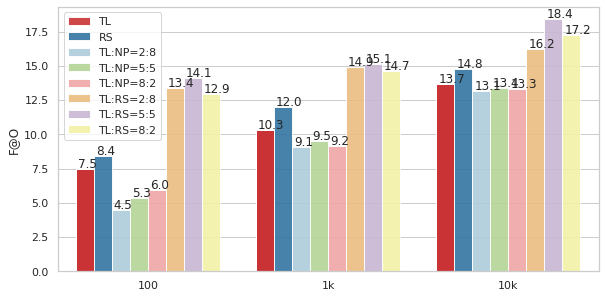

In [95]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_set2 = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Paired").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=0.9,
    palette=[_set2[5], _set2[1]] + _set2[0:6:2] + _set2[6:12:2]
#     palette=_set2[1:]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() + 0.01, p.get_height() + 0.1), rotation=0)
axes.set_title("")
axes.set_xlabel("")

axes.set_ylabel("F@O")
axes.legend(loc='upper left')

alphas = [1.0] * 3 + [0.2] * 9
for bar, alpha in zip(g.containers[0], alphas):
    bar.set_alpha(alpha)

### TL Zero-shot

In [92]:
# TF-DA-zeroshot
report_dirs = ['/zfs1/hdaqing/rum20/kp/transfer_exps_v2/tf_PTDA/report',
              '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_PTDA/report'
             ]

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for report_dir in report_dirs:
    for fname in os.listdir(report_dir):
        if not fname.endswith('.split_nopunc.csv'): continue
        df = pd.read_csv(os.path.join(report_dir, fname))
        df = df.loc[df.pred_name == pred_name]
        df = df.sort_values(by='step', ascending=True)

        all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)


In [99]:
short2long = {
# 'TF-KP20k-zeroshot': 'transformer-PT_wiki_step200k-DA_TLtf_kp20k_step20k',
# 'TF-OpenKP-zeroshot': 'transformer-PT_wiki_step200k-DA_TLtf_openkp_step20k',
# 'TF-KPTimes-zeroshot': 'transformer-PT_wiki_step200k-DA_TLtf_kptimes_step20k', 
# 'TF-StackEx-zeroshot': 'transformer-PT_wiki_step200k-DA_TLtf_stackex_step20k',
# 'NP-KP20k-zeroshot': 'transformer_DA-NP_kp20k_step100k',
# 'RS-KP20k-zeroshot': 'transformer_DA-RS_kp20k_step100k',
# 'TL-KP20k-zeroshot': 'transformer_DA-TL_kp20k_step100k',
    
'BART-KP20k-zeroshot': 'bart-DA_kp20k-TL_RS-lr1e5-step10k',
'BART-OpenKP-zeroshot': 'bart-DA_openkp-TL_RS-lr1e5-step10k',
'BART-KPTimes-zeroshot': 'bart-DA_kptimes-TL_RS-lr1e5-step10k', 
'BART-StackEx-zeroshot': 'bart-DA_stackex-TL_RS-lr1e5-step10k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['zeroshot']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []
# for short_name in short2long.keys():
#     model_setting, dataset_name, train_setting = short_name.split('-')
#     test_dataset = test_dataset.lower()
#     bar_dicts.append({
#         'model_setting': model_setting,
#         'test_dataset': dataset_name, 
#         'train_setting': train_setting,
#         'score': random.uniform(20, 50)
#     })

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
    
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

bart-DA_kp20k-TL_RS-lr1e5-step10k 4 kp20k_valid2k_test kp20k_test
bart-DA_openkp-TL_RS-lr1e5-step10k 4 openkp_valid2k_test openkp_test
bart-DA_kptimes-TL_RS-lr1e5-step10k 5 kptimes_valid2k_test kptimes_test
bart-DA_stackex-TL_RS-lr1e5-step10k 4 stackex_valid2k_test stackex_test


No handles with labels found to put in legend.


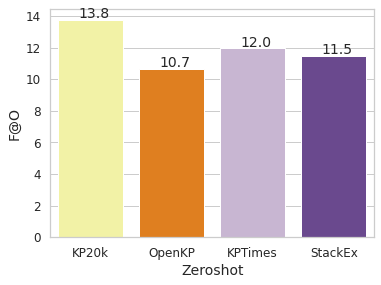

In [100]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

_set2 = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Paired").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(5, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df

sns.set_context("paper", font_scale=1.0, rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 18,
                             "legend.fontsize": 18})

sns.set(font_scale=1.2,
        rc={"font.size": 14,
            "axes.titlesize": 24,
            "axes.labelsize": 20,
            "xtick.labelsize": 20,
            "ytick.labelsize": 20,
            "legend.fontsize": 20})
g = sns.barplot(
    data=subbar_df,
    x="test_dataset", y="score",
    ax=axes, alpha=1.0,
    palette=[_set2[10], _set2[7], _set2[8], _set2[9]]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.1), rotation=0)
# axes.set_title(subbar_df['test_dataset'].iloc[0])
# axes.set_xticklabels([])
axes.set_xlabel("Zeroshot", fontsize=14)
axes.set_ylabel("F@O",fontsize=14)
# _, ylabels = plt.yticks()
# g.set_yticklabels(ylabels, size=15)
axes.legend(loc='upper left')
g.tick_params(labelsize=12)

axes.legend([],[], frameon=False)

### BART fewshot

In [47]:
# BART-fewshot
report_dirs = [
#     '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_FT/report/',
#     '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_DAFT/report/',
#     '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_PTDAFT/report/'
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_FT_devbest/report/',
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_DAFT_devbest/report/',
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_PTFT_devbest/report/',
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_PTDAFT_devbest/report/'
]

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for report_dir in report_dirs:
    for fname in os.listdir(report_dir):
        if not fname.endswith('.split_nopunc.csv'): continue
        df = pd.read_csv(os.path.join(report_dir, fname))
        df = df.loc[df.pred_name == pred_name]
        df = df.sort_values(by='step', ascending=True)

        all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
# print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())

In [58]:
short2long = {
# 'FT-KP20k-100': 'bart-FT_kp20k_fewshot100-bs16_step4k_clipnorm01_labelsmooth01',
# 'FT-KP20k-1k': 'bart-FT_kp20k_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01',
# 'FT-KP20k-10k': 'bart-FT_kp20k_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01',
'FT-KP20k-100': 'bart-FT_kp20k_fewshot100-bs16_step4k_clipnorm01_labelsmooth01-rerun-seed177',
'FT-KP20k-1k': 'bart-FT_kp20k_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01-rerun-seed177',
'FT-KP20k-10k': 'bart-FT_kp20k_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01-rerun-seed177',
'FT-OpenKP-100': 'bart-FT_openkp_fewshot100-bs16_step4k_clipnorm01_labelsmooth01',
'FT-OpenKP-1k': 'bart-FT_openkp_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01',
'FT-OpenKP-10k': 'bart-FT_openkp_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01', 
'FT-KPTimes-100': 'bart-FT_kptimes_fewshot100-bs16_step4k_clipnorm01_labelsmooth01',
# 'FT-KPTimes-1k': 'bart-FT_kptimes_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01',
'FT-KPTimes-1k': 'bart-FT_kptimes_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01-rerun',
'FT-KPTimes-10k': 'bart-FT_kptimes_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01',
'FT-StackEx-100': 'bart-FT_stackex_fewshot100-bs16_step4k_clipnorm01_labelsmooth01',
'FT-StackEx-1k': 'bart-FT_stackex_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01',
'FT-StackEx-10k': 'bart-FT_stackex_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01',

# 'DA+FT-KP20k-100': 'bart-kp20k-DA_step5k_bs256-FT100_bs16_step2k_clip01_labelsmooth01',
# 'DA+FT-KP20k-1k': 'bart-kp20k-DA_step5k_bs256-FT1k_bs16_step4k_clip01_labelsmooth01',
# 'DA+FT-KP20k-10k': 'bart-kp20k-DA_step5k_bs256-FT10k_bs16_step8k_clip01_labelsmooth01',
# 'DA+FT-OpenKP-100': 'bart-openkp-DA_step5k_bs256-FT100_bs16_step2k_clip01_labelsmooth01',
# 'DA+FT-OpenKP-1k': 'bart-openkp-DA_step5k_bs256-FT1k_bs16_step4k_clip01_labelsmooth01',
# 'DA+FT-OpenKP-10k': 'bart-openkp-DA_step5k_bs256-FT10k_bs16_step8k_clip01_labelsmooth01',
# 'DA+FT-KPTimes-100': 'bart-kptimes-DA_step5k_bs256-FT100_bs16_step2k_clip01_labelsmooth01',
# 'DA+FT-KPTimes-1k': 'bart-kptimes-DA_step5k_bs256-FT1k_bs16_step4k_clip01_labelsmooth01',
# 'DA+FT-KPTimes-10k': 'bart-kptimes-DA_step5k_bs256-FT10k_bs16_step8k_clip01_labelsmooth01',
# 'DA+FT-StackEx-100': 'bart-stackex-DA_step5k_bs256-FT100_bs16_step2k_clip01_labelsmooth01',
# 'DA+FT-StackEx-1k': 'bart-stackex-DA_step5k_bs256-FT1k_bs16_step4k_clip01_labelsmooth01',
# 'DA+FT-StackEx-10k': 'bart-stackex-DA_step5k_bs256-FT10k_bs16_step8k_clip01_labelsmooth01',

# 'PT+FT-KP20k-100': 'bart-kp20k-PT_step40k-FT100-bs16_step2k_clip01_labelsmooth01',
# 'PT+FT-KP20k-1k': 'bart-kp20k-PT_step40k-FT1k-bs16_step4k_clip01_labelsmooth01',
# 'PT+FT-KP20k-10k': 'bart-kp20k-PT_step40k-FT10k-bs16_step8k_clip01_labelsmooth01',
# 'PT+FT-OpenKP-100': 'bart-openkp-PT_step40k-FT100-bs16_step2k_clip01_labelsmooth01',
# 'PT+FT-OpenKP-1k': 'bart-openkp-PT_step40k-FT1k-bs16_step4k_clip01_labelsmooth01',
# 'PT+FT-OpenKP-10k': 'bart-openkp-PT_step40k-FT10k-bs16_step8k_clip01_labelsmooth01',
# 'PT+FT-KPTimes-100': 'bart-kptimes-PT_step40k-FT100-bs16_step2k_clip01_labelsmooth01',
# 'PT+FT-KPTimes-1k': 'bart-kptimes-PT_step40k-FT1k-bs16_step4k_clip01_labelsmooth01',
# 'PT+FT-KPTimes-10k': 'bart-kptimes-PT_step40k-FT10k-bs16_step8k_clip01_labelsmooth01',
# 'PT+FT-StackEx-100': 'bart-stackex-PT_step40k-FT100-bs16_step2k_clip01_labelsmooth01',
# 'PT+FT-StackEx-1k': 'bart-stackex-PT_step40k-FT1k-bs16_step4k_clip01_labelsmooth01',
# 'PT+FT-StackEx-10k': 'bart-stackex-PT_step40k-FT10k-bs16_step8k_clip01_labelsmooth01',

'PT+DA+FT-KP20k-100': 'bart-PT_step40k-DA_kp20k_step5k-FT1e5_fewshot100-bs16_step2k_clip01_labelsmooth01',
'PT+DA+FT-KP20k-1k': 'bart-PT_step40k-DA_kp20k_step5k-FT1e5_fewshot1k-bs16_step4k_clip01_labelsmooth01',
'PT+DA+FT-KP20k-10k': 'bart-PT_step40k-DA_kp20k_step5k-FT1e5_fewshot10k-bs16_step8k_clip01_labelsmooth01',
'PT+DA+FT-OpenKP-100': 'bart-PT_step40k-DA_openkp_step5k-FT1e5_fewshot100-bs16_step2k_clip01_labelsmooth01',
'PT+DA+FT-OpenKP-1k': 'bart-PT_step40k-DA_openkp_step5k-FT1e5_fewshot1k-bs16_step4k_clip01_labelsmooth01',
'PT+DA+FT-OpenKP-10k': 'bart-PT_step40k-DA_openkp_step5k-FT1e5_fewshot10k-bs16_step8k_clip01_labelsmooth01',
'PT+DA+FT-KPTimes-100': 'bart-PT_step40k-DA_kptimes_step5k-FT1e5_fewshot100-bs16_step2k_clip01_labelsmooth01',
'PT+DA+FT-KPTimes-1k': 'bart-PT_step40k-DA_kptimes_step5k-FT1e5_fewshot1k-bs16_step4k_clip01_labelsmooth01',
'PT+DA+FT-KPTimes-10k': 'bart-PT_step40k-DA_kptimes_step5k-FT1e5_fewshot10k-bs16_step8k_clip01_labelsmooth01',
'PT+DA+FT-StackEx-100': 'bart-PT_step40k-DA_stackex_step5k-FT1e5_fewshot100-bs16_step2k_clip01_labelsmooth01',
'PT+DA+FT-StackEx-1k': 'bart-PT_step40k-DA_stackex_step5k-FT1e5_fewshot1k-bs16_step4k_clip01_labelsmooth01',
'PT+DA+FT-StackEx-10k': 'bart-PT_step40k-DA_stackex_step5k-FT1e5_fewshot10k-bs16_step8k_clip01_labelsmooth01',
}

long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')
                 ]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
# anchor_metric_name = 'all_exact_f_score@10'
# anchor_metric_name = 'all_exact_advanced_sadr'
# anchor_metric_name = 'all_exact_advanced_ndcg'
# anchor_metric_name = 'all_exact_advanced_alpha_ndcg@10'
# anchor_metric_name = 'all_exact_advanced_auc'
# anchor_metric_name = 'all_exact_advanced_mrr'


bar_dicts = []
avg_score_map = {}

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

#         print(exp_name, len(exp_grp), dev_dataset, test_dataset)
        print(model_setting, dataset_name, train_setting)
#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        avg_key = f"{model_setting}-{train_setting}"
        avg_score = avg_score_map.get(avg_key, 0.0)
        avg_score_map[avg_key] = avg_score + best_test_row[anchor_metric_name].values[0]

avg_bar_dicts = []
for avg_key, avg_score in avg_score_map.items():
    model_setting, train_setting = avg_key.split('-')
    avg_bar_dicts.append({
            'model_setting': model_setting,
            'train_setting': train_setting,
            'score': avg_score / 4 * 100.0
        })

FT KP20k 100
FT KP20k 1k
FT KP20k 10k
PT+DA+FT KP20k 100
PT+DA+FT KP20k 1k
PT+DA+FT KP20k 10k
FT OpenKP 100
FT OpenKP 1k
FT OpenKP 10k
PT+DA+FT OpenKP 100
PT+DA+FT OpenKP 1k
PT+DA+FT OpenKP 10k
FT KPTimes 100
FT KPTimes 1k
FT KPTimes 10k
PT+DA+FT KPTimes 100
PT+DA+FT KPTimes 1k
PT+DA+FT KPTimes 10k
FT StackEx 100
FT StackEx 1k
FT StackEx 10k
PT+DA+FT StackEx 100
PT+DA+FT StackEx 1k
PT+DA+FT StackEx 10k


[(20.0, 55.0)]

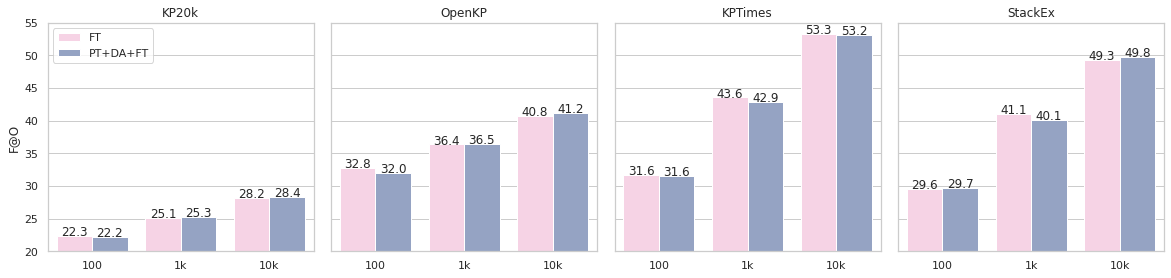

In [60]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 6,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
#         palette=[_set3[7], _set3[8], _set3[9], _set2[2]]
        palette=[_set3[7], _set2[2]]
    )
    
    for p in axes[fig_id].patches:
#         axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() - 0.01, p.get_height()+np.random.normal(0,0.8) + 0.05), rotation=0, fontsize=10)
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.05), rotation=0, fontsize=12)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")

    if fig_id == 0:
        axes[fig_id].set_ylabel("F@O")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)
        
axes[0].set(ylim=(20, 55))
# axes[0].set(ylim=(25, 70))


[(20.0, 45.0)]

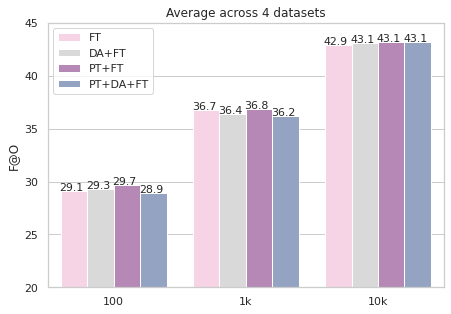

In [105]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=avg_bar_dicts)

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

g = sns.barplot(
    data=bar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=ax, alpha=1.0,
    palette=[_set3[7], _set3[8], _set3[9], _set2[2]]
)

for p in ax.patches:
    ax.annotate('%.1f' % (p.get_height()), (p.get_x() - 0.01, p.get_height() + 0.05), rotation=0, fontsize=11)
ax.set_title("Average across 4 datasets")
ax.set_xlabel("")

ax.set_ylabel("F@O")
ax.legend(loc='upper left')

ax.set(ylim=(20, 45))

#### present

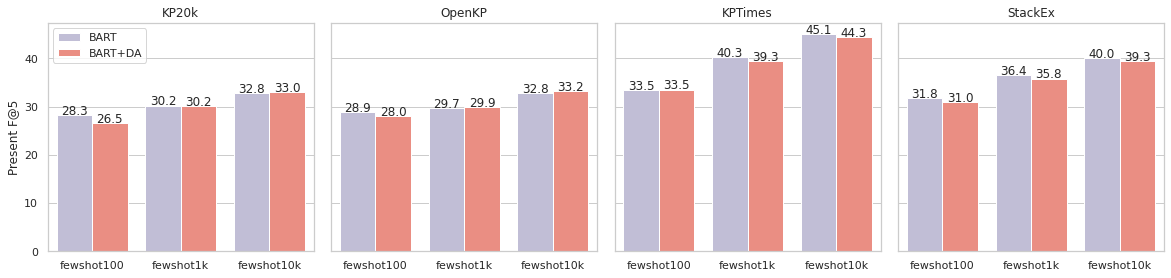

In [106]:
short2long = {
'BART-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
'BART-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
'BART-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART-OpenKP-fewshot100': 'bart_presabs_openkp_fewshot100',
'BART-OpenKP-fewshot1k': 'bart_presabs_openkp_fewshot1k',
'BART-OpenKP-fewshot10k': 'bart_presabs_openkp_fewshot10k_step10k_rerun', 
'BART-KPTimes-fewshot100': 'bart_presabs_kptimes_fewshot100',
'BART-KPTimes-fewshot1k': 'bart_presabs_kptimes_fewshot1k',
'BART-KPTimes-fewshot10k': 'bart_presabs_kptimes_fewshot10k_step10k_rerun',
'BART-StackEx-fewshot100': 'bart_presabs_stackex_fewshot100',
'BART-StackEx-fewshot1k': 'bart_presabs_stackex_fewshot1k',
'BART-StackEx-fewshot10k': 'bart_presabs_stackex_fewshot10k_step10k_rerun',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-OpenKP-fewshot100': 'bart-openkp-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-OpenKP-fewshot1k': 'bart-openkp-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-OpenKP-fewshot10k': 'bart-openkp-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-KPTimes-fewshot100': 'bart-kptimes-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-KPTimes-fewshot1k': 'bart-kptimes-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KPTimes-fewshot10k': 'bart-kptimes-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-StackEx-fewshot100': 'bart-stackex-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-StackEx-fewshot1k': 'bart-stackex-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-StackEx-fewshot10k': 'bart-stackex-fewshot10k-DA1e5_step1k-FT5e6_step4k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'present_exact_f_score@5'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[2], _set3[3]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Present F@5")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

#### absent

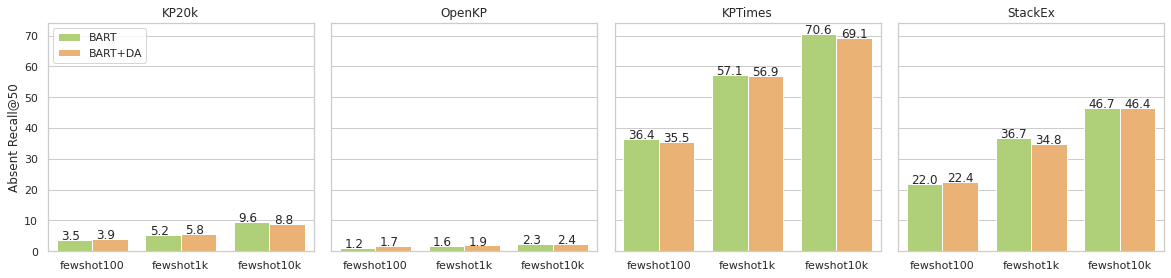

In [107]:
short2long = {
'BART-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
'BART-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
'BART-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART-OpenKP-fewshot100': 'bart_presabs_openkp_fewshot100',
'BART-OpenKP-fewshot1k': 'bart_presabs_openkp_fewshot1k',
'BART-OpenKP-fewshot10k': 'bart_presabs_openkp_fewshot10k_step10k_rerun', 
'BART-KPTimes-fewshot100': 'bart_presabs_kptimes_fewshot100',
'BART-KPTimes-fewshot1k': 'bart_presabs_kptimes_fewshot1k',
'BART-KPTimes-fewshot10k': 'bart_presabs_kptimes_fewshot10k_step10k_rerun',
'BART-StackEx-fewshot100': 'bart_presabs_stackex_fewshot100',
'BART-StackEx-fewshot1k': 'bart_presabs_stackex_fewshot1k',
'BART-StackEx-fewshot10k': 'bart_presabs_stackex_fewshot10k_step10k_rerun',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-OpenKP-fewshot100': 'bart-openkp-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-OpenKP-fewshot1k': 'bart-openkp-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-OpenKP-fewshot10k': 'bart-openkp-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-KPTimes-fewshot100': 'bart-kptimes-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-KPTimes-fewshot1k': 'bart-kptimes-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KPTimes-fewshot10k': 'bart-kptimes-fewshot10k-DA1e5_step1k-FT5e6_step4k',
'BART+DA-StackEx-fewshot100': 'bart-stackex-fewshot100-DA1e5_step1k-FT5e6_step1k',
'BART+DA-StackEx-fewshot1k': 'bart-stackex-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-StackEx-fewshot10k': 'bart-stackex-fewshot10k-DA1e5_step1k-FT5e6_step4k',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'absent_exact_recall@50'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        

# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_pastel = sns.color_palette("pastel").as_hex()
_husl = sns.color_palette("husl").as_hex()
_set2 = sns.color_palette("Set2").as_hex()
_set3 = sns.color_palette("Set3").as_hex()
# sns.set_palette(_set2[5:])

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

for fig_id, (data_name, dev_dataset, test_dataset) in enumerate(dev_test_pairs):
    subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == data_name]

    g = sns.barplot(
        data=subbar_df,
        x="train_setting", y="score", hue="model_setting",
        ax=axes[fig_id], alpha=1.0,
        palette=[_set3[6], _set3[5]] #_set3[7:]
    )
#     g.set_ylim(22, 38)
    for p in axes[fig_id].patches:
        axes[fig_id].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.05, p.get_height() + 0.1), rotation=0)
    axes[fig_id].set_title(subbar_df['test_dataset'].iloc[0])
    axes[fig_id].set_xlabel("")
    
    if fig_id == 0:
        axes[fig_id].set_ylabel("Absent Recall@50")
        axes[fig_id].legend(loc='upper left')
    else:
        axes[fig_id].set_ylabel("")
        axes[fig_id].legend([],[], frameon=False)

### DA-MagTL

In [65]:
# BART-mag
report_dirs = [
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/mag_DAFT_devbest/report/', # TF MAG
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/mag_DAbs256_FTbs16_devbest/report/', # BART MAG
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/tf_PTDAFT_devbest/report', # TF
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_FT_devbest/report/', # BART FT
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_DAFT_devbest/report/', # BART DAFT
    '/zfs1/hdaqing/rum20/kp/transfer_exps_v2/bart_PTDAFT_devbest/report/', # BART PTDAFT
    '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/cross_domain_exps/kp_o2s_fulldata_devbest', # exps using all data
    '/zfs1/pbrusilovsky/rum20/kp/transfer_exps_v1/empirical_mag/report/', # previous SOTA
]
pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for report_dir in report_dirs:
    for fname in os.listdir(report_dir):
        if not fname.endswith('.split_nopunc.csv'): continue
        df = pd.read_csv(os.path.join(report_dir, fname))
        df = df.loc[df.pred_name == pred_name]
        df = df.sort_values(by='step', ascending=True)

        all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)


In [67]:
short2long = {
# Transformer
'TF,PT+DA+FT,KP20k-100k,KP20k,100': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot100_step1k_lr1e5',
'TF,PT+DA+FT,KP20k-100k,KP20k,1k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot1k_step2k_lr1e5',
'TF,PT+DA+FT,KP20k-100k,KP20k,10k': 'transformer-PTDA_tlrs55-FT_kp20k_fewshot10k_step4k_lr1e5',

'TF,PT+DA+FT,MagCS-1m,KP20k,100': 'transformer-kp20k-PTDAFT-magcs1m-fewshot100-step1k-lr1e5',
'TF,PT+DA+FT,MagCS-1m,KP20k,1k': 'transformer-kp20k-PTDAFT-magcs1m-fewshot1k-step2k-lr1e5',
'TF,PT+DA+FT,MagCS-1m,KP20k,10k': 'transformer-kp20k-PTDAFT-magcs1m-fewshot10k-step4k-lr1e5',

'TF,PT+DA+FT,MagCS-12m,KP20k,100': 'transformer-PTDAFT-kp20k-magcs12m-fewshot100-step1k-lr1e5',
'TF,PT+DA+FT,MagCS-12m,KP20k,1k': 'transformer-kp20k-PTDAFT-magcs12m-fewshot1k-step2k-lr1e5',
'TF,PT+DA+FT,MagCS-12m,KP20k,10k': 'transformer-kp20k-PTDAFT-magcs12m-fewshot10k-step4k-lr1e5',

# BART
# FT
# 'BART,FT,KP20k,100': 'bart-FT_kp20k_fewshot100-bs16_step4k_clipnorm01_labelsmooth01',
# 'BART,FT,KP20k,1k': 'bart-FT_kp20k_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01',
# 'BART,FT,KP20k,10k': 'bart-FT_kp20k_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01',
# 'BART,FT,KP20k,100': 'bart-FT_kp20k_fewshot100-bs16_step4k_clipnorm01_labelsmooth01-rerun-seed177',
# 'BART,FT,KP20k,1k': 'bart-FT_kp20k_fewshot1k-bs16_step4k_clipnorm01_labelsmooth01-rerun-seed177',
# 'BART,FT,KP20k,10k': 'bart-FT_kp20k_fewshot10k-bs16_step8k_clipnorm01_labelsmooth01-rerun-seed177',

# DAFT, DA bs256
# 'BART,DA+FT,KP20k-100k,KP20k,100': 'bart-kp20k-DA_step5k_bs256-FT100_bs16_step2k_clip01_labelsmooth01',
# 'BART,DA+FT,KP20k-100k,KP20k,1k': 'bart-kp20k-DA_step5k_bs256-FT1k_bs16_step4k_clip01_labelsmooth01',
# 'BART,DA+FT,KP20k-100k,KP20k,10k': 'bart-kp20k-DA_step5k_bs256-FT10k_bs16_step8k_clip01_labelsmooth01',
    
# 'BART,DA+FT,MagCS-1m,KP20k,100': 'bart-kp20k-DA_magcs1m_step5k_tlrs55-FT100-bs16_step2k_clip01_labelsmooth01',
# 'BART,DA+FT,MagCS-1m,KP20k,1k': 'bart-kp20k-DA_magcs1m_step5k_tlrs55-FT1k-bs16_step4k_clip01_labelsmooth01',
# 'BART,DA+FT,MagCS-1m,KP20k,10k': 'bart-kp20k-DA_magcs1m_step5k_tlrs55-FT10k-bs16_step8k_clip01_labelsmooth01',

# 'BART,DA+FT,MagCS-12m,KP20k,100': 'bart-kp20k-DA_magcs12m_step20k_tlrs55-FT100-bs16_step2k_clip01_labelsmooth01',
# 'BART,DA+FT,MagCS-12m,KP20k,1k': 'bart-kp20k-DA_magcs12m_step20k_tlrs55-FT1k-bs16_step4k_clip01_labelsmooth01',
# 'BART,DA+FT,MagCS-12m,KP20k,10k': 'bart-kp20k-DA_magcs12m_step20k_tlrs55-FT10k-bs16_step8k_clip01_labelsmooth01',

# PTDAFT DA bs256
'BART,PT+DA+FT,KP20k-100k,KP20k,100': 'bart-PT_step40k-DA_kp20k_step5k-FT1e5_fewshot100-bs16_step2k_clip01_labelsmooth01',
'BART,PT+DA+FT,KP20k-100k,KP20k,1k': 'bart-PT_step40k-DA_kp20k_step5k-FT1e5_fewshot1k-bs16_step4k_clip01_labelsmooth01',
'BART,PT+DA+FT,KP20k-100k,KP20k,10k': 'bart-PT_step40k-DA_kp20k_step5k-FT1e5_fewshot10k-bs16_step8k_clip01_labelsmooth01',

'BART,PT+DA+FT,MagCS-1m,KP20k,100': 'bart-PT_step40k-DA_magcs1m_step5k-FT1e5_kp20k100-bs16_step2k_clip01_labelsmooth01',
'BART,PT+DA+FT,MagCS-1m,KP20k,1k': 'bart-PT_step40k-DA_magcs1m_step5k-FT1e5_kp20k1k-bs16_step4k_clip01_labelsmooth01',
'BART,PT+DA+FT,MagCS-1m,KP20k,10k': 'bart-PT_step40k-DA_magcs1m_step5k-FT1e5_kp20k10k-bs16_step8k_clip01_labelsmooth01',

'BART,PT+DA+FT,MagCS-12m,KP20k,100': 'bart-PT_step40k-DA_magcs12m_step20k-FT1e5_kp20k100-bs16_step2k_clip01_labelsmooth01',
'BART,PT+DA+FT,MagCS-12m,KP20k,1k': 'bart-PT_step40k-DA_magcs12m_step20k-FT1e5_kp20k1k-bs16_step4k_clip01_labelsmooth01',
'BART,PT+DA+FT,MagCS-12m,KP20k,10k': 'bart-PT_step40k-DA_magcs12m_step20k-FT1e5_kp20k10k-bs16_step8k_clip01_labelsmooth01',

# 'TF-KP20k-full': 'transformer_presabs_kp20k',
# 'PrevSOTA-KP20k-full': 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
# dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_valid2k_test'), 
#                   ('openkp', 'openkp_valid2k_test', 'openkp_valid2k_test'),
#                   ('kptimes', 'kptimes_valid2k_test', 'kptimes_valid2k_test'),
#                   ('stackex', 'stackex_valid2k_test', 'stackex_valid2k_test')]

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []

for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_name, model_setting, da_dataset, ft_dataset, ft_setting = short_name.split(',')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

#         display(exp_grp[['exp_name', 'test_dataset', 'step', anchor_metric_name]])
#         exp_grp = exp_grp.loc[exp_grp['test_dataset'].isin(datasets)]

        if not short_name.startswith('TF') and not short_name.startswith('BART'):
            dev_dataset = dev_dataset[:-5]
            test_dataset = test_dataset[:-5]
        print(exp_name, len(exp_grp), dev_dataset, test_dataset)
        print('\t'.join([model_name, model_setting, da_dataset, ft_dataset, ft_setting]))
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_name': model_name+' '+model_setting,
            'model_setting': model_setting,
            'DA_dataset': da_dataset, 
            'FT_setting': ft_setting,
            'FT_dataset': ft_dataset, 
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        
# print(train_test_scores)

transformer-PTDA_tlrs55-FT_kp20k_fewshot100_step1k_lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	KP20k-100k	KP20k	100
transformer-PTDA_tlrs55-FT_kp20k_fewshot1k_step2k_lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	KP20k-100k	KP20k	1k
transformer-PTDA_tlrs55-FT_kp20k_fewshot10k_step4k_lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	KP20k-100k	KP20k	10k
transformer-kp20k-PTDAFT-magcs1m-fewshot100-step1k-lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	MagCS-1m	KP20k	100
transformer-kp20k-PTDAFT-magcs1m-fewshot1k-step2k-lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	MagCS-1m	KP20k	1k
transformer-kp20k-PTDAFT-magcs1m-fewshot10k-step4k-lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	MagCS-1m	KP20k	10k
transformer-PTDAFT-kp20k-magcs12m-fewshot100-step1k-lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	MagCS-12m	KP20k	100
transformer-kp20k-PTDAFT-magcs12m-fewshot1k-step2k-lr1e5 3 kp20k_valid2k_test kp20k_test
TF	PT+DA+FT	MagCS-12m	KP20k	1k
transformer-kp20k-PTDAFT-magcs12m-fe

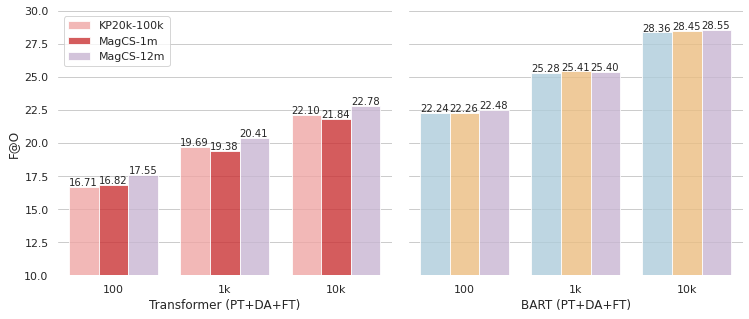

In [70]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_husl = sns.color_palette("husl").as_hex()
_paired = sns.color_palette("Paired").as_hex()
_set2 = sns.color_palette("Set2").as_hex()

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[(bar_df['FT_dataset'].str.lower() == 'kp20k') & (bar_df['model_name'] == 'TF PT+DA+FT')]
g0 = sns.barplot(
    data=subbar_df,
    x="FT_setting", y="score", hue="DA_dataset",
    ax=axes[0], alpha=0.8,
    palette=_paired[4:6] + _paired[8:10] + _paired[6:8]
)
# subbar_df = bar_df.loc[(bar_df['FT_dataset'].str.lower() == 'kp20k') & (bar_df['model_name'] == 'BART DA+FT')]
# g1 = sns.barplot(
#     data=subbar_df,
#     x="FT_setting", y="score", hue="DA_dataset",
#     ax=axes[1], alpha=0.8,
#     palette=[_paired[0], _paired[6], _paired[8]]
# )
subbar_df = bar_df.loc[(bar_df['FT_dataset'].str.lower() == 'kp20k') & (bar_df['model_name'] == 'BART PT+DA+FT')]
g2 = sns.barplot(
    data=subbar_df,
    x="FT_setting", y="score", hue="DA_dataset",
    ax=axes[1], alpha=0.8,
    palette=[_paired[0], _paired[6], _paired[8]]
)

for p in axes[0].patches:
    axes[0].annotate('%.2f' % (p.get_height()), (p.get_x() - 0.0, p.get_height() + 0.1), rotation=0, fontsize=10)
# for p in axes[1].patches:
#     axes[1].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.025, p.get_height() + 0.1), rotation=0, fontsize=10)
for p in axes[1].patches:
    axes[1].annotate('%.2f' % (p.get_height()), (p.get_x() - 0.0, p.get_height() + 0.1), rotation=0, fontsize=10)

axes[0].set_title("")
axes[0].set_xlabel("Transformer (PT+DA+FT)")
# axes[1].set_xlabel("BART (DA+FT)")
axes[1].set_xlabel("BART (PT+DA+FT)")

axes[0].set(ylim=(10, 30))
axes[0].set_ylabel("F@O")
axes[1].set_ylabel("")
axes[0].legend(loc='upper left')

# axes[0].grid(False)
# axes[1].grid(False)

# g1.legend_.remove()
g2.legend_.remove()

sns.despine(left=True, bottom=True, right=True)

#### present

['#cab2d6', '#6a3d9a', '#fb9a99', '#e31a1c', '#ffff99', '#b15928']


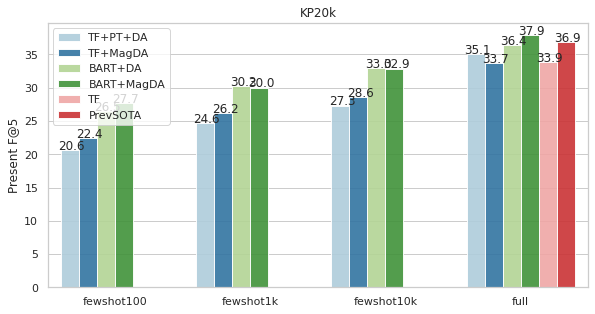

In [6]:
short2long = {
# 'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
# 'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
# 'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
# 'TF+DA-KP20k-full': 'transformer_presabs_kp20k',
'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KP20k-full': 'transformer-kp20k-PT_step200k-DA_step20k-FT_full_step100k_lr5e5_warmup10k',

'TF+MagDA-KP20k-fewshot100': 'transformer-kp20k-DA_mag_step500k-FT_fewshot100_step1k_lr1e5',
'TF+MagDA-KP20k-fewshot1k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot1k_step2k_lr1e5',
'TF+MagDA-KP20k-fewshot10k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot10k_step4k_lr1e5',
'TF+MagDA-KP20k-full': 'transformer-kp20k-DA_mag_step500k-FT_full_step100k_lr1e5',

'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
# 'BART+DA-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
# 'BART+DA-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
# 'BART+DA-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART+DA-KP20k-full': 'bartFT_presabs_kp20k_100k_rerun',
    
'BART+MagDA-KP20k-fewshot100': 'bart-MagTL_step100k-FT_kp20k_fewshot100_lr5e6_step1k',
'BART+MagDA-KP20k-fewshot1k': 'bart-MagTL_step100k-FT_kp20k_fewshot1k_lr5e6_step2k',
'BART+MagDA-KP20k-fewshot10k': 'bart-MagTL_step100k-FT_kp20k_fewshot10k_lr5e6_step4k',
'BART+MagDA-KP20k-full': 'bart-MagTL_step100k-kp20k_full_lr1e5_step50k',
    
'TF-KP20k-full': 'transformer_presabs_kp20k',
'PrevSOTA-KP20k-full': 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in short2long.items()}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'present_exact_f_score@5'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)
        
        if not short_name.startswith('TF') and not short_name.startswith('BART'):
            dev_dataset = dev_dataset[:-5]
            test_dataset = test_dataset[:-5]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_husl = sns.color_palette("husl").as_hex()
_paired = sns.color_palette("Paired").as_hex()
_set2 = sns.color_palette("Set2").as_hex()

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

print(_paired[8:10] + _paired[4:6] + _paired[10:12])
g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=0.9,
    palette=_paired
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() - 0.02, p.get_height() + 0.1), rotation=0)
axes.set_title(subbar_df['test_dataset'].iloc[0])
axes.set_xlabel("")

# axes.set(ylim=(10, 35))
axes.set_ylabel("Present F@5")
axes.legend(loc='upper left')


#### absent

['#cab2d6', '#6a3d9a', '#fb9a99', '#e31a1c', '#ffff99', '#b15928']


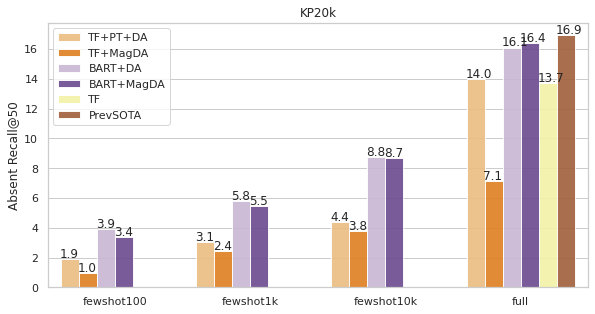

In [7]:
short2long = {
# 'TF+DA-KP20k-fewshot100': 'transformer-kp20k-DA_step50k-FT_fewshot100_step1k_lr1e5',
# 'TF+DA-KP20k-fewshot1k': 'transformer-kp20k-DA_step50k-FT_fewshot1k_step2k_lr1e5',
# 'TF+DA-KP20k-fewshot10k': 'transformer-kp20k-DA_step50k-FT_fewshot10k_step4k_lr1e5',
# 'TF+DA-KP20k-full': 'transformer_presabs_kp20k',
'TF+PT+DA-KP20k-fewshot100': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot100_step1k_lr1e5',
'TF+PT+DA-KP20k-fewshot1k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot1k_step2k_lr1e5',
'TF+PT+DA-KP20k-fewshot10k': 'transformer-kp20k-PT_step200k-DA_step20k-FT_fewshot10k_step4k_lr1e5',
'TF+PT+DA-KP20k-full': 'transformer-kp20k-PT_step200k-DA_step20k-FT_full_step100k_lr5e5_warmup10k',

'TF+MagDA-KP20k-fewshot100': 'transformer-kp20k-DA_mag_step500k-FT_fewshot100_step1k_lr1e5',
'TF+MagDA-KP20k-fewshot1k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot1k_step2k_lr1e5',
'TF+MagDA-KP20k-fewshot10k': 'transformer-kp20k-DA_mag_step500k-FT_fewshot10k_step4k_lr1e5',
'TF+MagDA-KP20k-full': 'transformer-kp20k-DA_mag_step500k-FT_full_step100k_lr1e5',
    
'BART+DA-KP20k-fewshot100': 'bart-kp20k-fewshot100-DA1e5_step3k-FT5e6_step1k',
'BART+DA-KP20k-fewshot1k': 'bart-kp20k-fewshot1k-DA1e5_step1k-FT5e6_step2k',
'BART+DA-KP20k-fewshot10k': 'bart-kp20k-fewshot10k-DA1e5_step1k-FT5e6_step4k',
# 'BART+DA-KP20k-fewshot100': 'bart_presabs_kp20k_fewshot100',
# 'BART+DA-KP20k-fewshot1k': 'bart_presabs_kp20k_fewshot1k',
# 'BART+DA-KP20k-fewshot10k': 'bart_presabs_kp20k_fewshot10k_step10k_rerun',
'BART+DA-KP20k-full': 'bartFT_presabs_kp20k_100k_rerun',
    
'BART+MagDA-KP20k-fewshot100': 'bart-MagTL_step100k-FT_kp20k_fewshot100_lr5e6_step1k',
'BART+MagDA-KP20k-fewshot1k': 'bart-MagTL_step100k-FT_kp20k_fewshot1k_lr5e6_step2k',
'BART+MagDA-KP20k-fewshot10k': 'bart-MagTL_step100k-FT_kp20k_fewshot10k_lr5e6_step4k',
'BART+MagDA-KP20k-full': 'bart-MagTL_step100k-kp20k_full_lr1e5_step50k',
    
'TF-KP20k-full': 'transformer_presabs_kp20k',
'PrevSOTA-KP20k-full': 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in short2long.items()}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]

anchor_metric_name = 'all_exact_f_score@k'
report_metric_name = 'absent_exact_recall@50'

bar_dicts = []
for data_name, dev_dataset, test_dataset in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        model_setting, dataset_name, train_setting = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)
        
        if not short_name.startswith('TF') and not short_name.startswith('BART'):
            dev_dataset = dev_dataset[:-5]
            test_dataset = test_dataset[:-5]
        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, test_dataset, anchor_metric_name)
        bar_dicts.append({
            'model_setting': model_setting,
            'test_dataset': dataset_name, 
            'train_setting': train_setting,
            'score': best_test_row[report_metric_name].values[0] * 100.0
        })
        
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 24,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_husl = sns.color_palette("husl").as_hex()
_paired = sns.color_palette("Paired").as_hex()
_set2 = sns.color_palette("Set2").as_hex()

sns.set_theme(style="whitegrid")
f, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

subbar_df = bar_df.loc[bar_df['test_dataset'].str.lower() == 'kp20k']

print(_paired[8:10] + _paired[4:6] + _paired[10:12])
g = sns.barplot(
    data=subbar_df,
    x="train_setting", y="score", hue="model_setting",
    ax=axes, alpha=0.9,
    palette=_paired[6:]
)

for p in axes.patches:
    axes.annotate('%.1f' % (p.get_height()), (p.get_x() - 0.01, p.get_height() + 0.1), rotation=0)
axes.set_title(subbar_df['test_dataset'].iloc[0])
axes.set_xlabel("")

# axes.set(ylim=(10, 35))
axes.set_ylabel("Absent Recall@50")
axes.legend(loc='upper left')


### Self-learning results (10 iters)

In [3]:
# fulldata
report_dir = '/Users/memray/Downloads/report'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

    print(len(all_eval_df))
print(all_eval_df.test_dataset.unique())
print(all_eval_df.exp_name.unique())
print(all_eval_df.test_dataset.unique())

400
['kp20k_valid2k_test']
['transformer-PTDA_kp20k_round1-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round3-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round4-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round5-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round6-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round7-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round8-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round9-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_kp20k_round2-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_magkp1m_round1-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_magkp1m_round2-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_magkp1m_round3-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_magkp1m_round4-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_magkp1m_round5-FT_kp20k_fewshot10k_step4k_lr1e5'
 'transformer-PTDA_magkp1m_round6-FT_kp

In [67]:
short2long = {
'KP20k 100k-KP20k-1': 'transformer-PTDA_kp20k_round1-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-2': 'transformer-PTDA_kp20k_round2-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-3': 'transformer-PTDA_kp20k_round3-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-4': 'transformer-PTDA_kp20k_round4-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-5': 'transformer-PTDA_kp20k_round5-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-6': 'transformer-PTDA_kp20k_round6-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-7': 'transformer-PTDA_kp20k_round7-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-8': 'transformer-PTDA_kp20k_round8-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-9': 'transformer-PTDA_kp20k_round9-FT_kp20k_fewshot10k_step4k_lr1e5',
'KP20k 100k-KP20k-10': 'transformer-PTDA_kp20k_round10-FT_kp20k_fewshot10k_step4k_lr1e5',

'MagCS 1m-KP20k-1': 'transformer-PTDA_magkp1m_round1-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-2': 'transformer-PTDA_magkp1m_round2-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-3': 'transformer-PTDA_magkp1m_round3-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-4': 'transformer-PTDA_magkp1m_round4-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-5': 'transformer-PTDA_magkp1m_round5-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-6': 'transformer-PTDA_magkp1m_round6-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-7': 'transformer-PTDA_magkp1m_round7-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-8': 'transformer-PTDA_magkp1m_round8-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-9': 'transformer-PTDA_magkp1m_round9-FT_kp20k_fewshot10k_step4k_lr1e5',
'MagCS 1m-KP20k-10': 'transformer-PTDA_magkp1m_round10-FT_kp20k_fewshot10k_step4k_lr1e5'

}

long2short = {long: short for short, long in short2long.items()}
# long2short = {n: n for n in sorted(all_eval_df.exp_name.unique())}

dev_test_pairs = [('kp20k', 'kp20k_valid2k_test', 'kp20k_test'), 
                  ('openkp', 'openkp_valid2k_test', 'openkp_test'),
                  ('kptimes', 'kptimes_valid2k_test', 'kptimes_test'),
                  ('stackex', 'stackex_valid2k_test', 'stackex_test')]
setting_names = ['fewshot100', 'fewshot1k', 'fewshot10k']

anchor_metric_name = 'all_exact_f_score@k'

bar_dicts = []

for data_name, dev_dataset, _ in dev_test_pairs:
    for short_name, exp_name in short2long.items():
        if not data_name in exp_name: continue

        train_dataname, test_dataname, round_iter = short_name.split('-')
        exp_grp = all_eval_df.loc[all_eval_df['exp_name'] == exp_name]
        exp_grp = exp_grp.sort_values(by='step', ascending=True)

        best_test_row = best_testscores_by_dev(exp_grp, dev_dataset, dev_dataset, anchor_metric_name)
        bar_dicts.append({
            'train_dataname': train_dataname,
            'test_dataname': test_dataname, 
            'round_iter': str(int(round_iter)),
            'score': best_test_row[anchor_metric_name].values[0] * 100.0
        })
        

/var/folders/p5/3r_xtg1x7kb4hc_r955731vc0000gn/T/ipykernel_84159/2541090818.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['{:.0f}'.format(i) for i in range(1, 11)], fontsize=14)
/var/folders/p5/3r_xtg1x7kb4hc_r955731vc0000gn/T/ipykernel_84159/2541090818.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['{:.1f}'.format(i) for i in g.get_yticks()], fontsize=14)


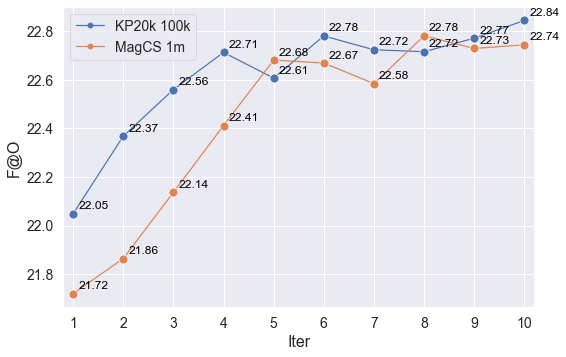

In [97]:
# Set up the matplotlib figure
bar_df = pd.DataFrame(data=bar_dicts)
# display(bar_df)

sns.set_theme(style="darkgrid")
f, axes = plt.subplots(1, 1, figsize=(7,4.5), sharex=True, sharey=True)
f.tight_layout(pad=0.0)

sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 16,
                             "axes.labelsize": 16,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 16,
                             "legend.fontsize": 14})

g = sns.lineplot(data=bar_df, x="round_iter", y="score", hue="train_dataname",
                 style="train_dataname", markers=["o", "o"],
                 dashes=False, markersize=9)

axes.set_title("")
axes.set_xlabel("Iter", fontsize=16)
axes.set_ylabel("F@O", fontsize=16)
axes.legend(loc='upper left', fontsize=14)

g.set_xticklabels(['{:.0f}'.format(i) for i in range(1, 11)], fontsize=14)
g.set_yticklabels(['{:.1f}'.format(i) for i in g.get_yticks()], fontsize=14)

axes.set(xlim=(-0.2, 9.2))

# label points on the plot
for x, y in zip(bar_df['round_iter'], bar_df['score']):
    plt.text(x=float(x)-1.9, # x-coordinate position of data label
    y = y+0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
    s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
    color='black', fontsize=12) # set colour of line

### Others

In [ ]:
# fulldata
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_o2s_fulldata_devbest/report/'

# TF-fewshot
# report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_DA_devbest/report/'
report_dir = '/zfs1/pbrusilovsky/rum20/kp/transfer_exps/kp_transformer_fewshot_devbest/report/'

# BART-fewshot
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_bart_DA/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v1-DA1e6_FT1e5/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v2/report/'
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_fewshot-v3/report/'

# BART-mag
# report_dir = '/zfs1/hdaqing/rum20/kp/transfer_exps/kp_mag_fewshot/report/'

pred_name = 'beamsearch-width_50-maxlen_40'

all_eval_df = None
for fname in os.listdir(report_dir):
    if not fname.endswith('.split_nopunc.csv'): continue
    df = pd.read_csv(os.path.join(report_dir, fname))
    df = df.loc[df.pred_name == pred_name]
    df = df.sort_values(by='step', ascending=True)

    all_eval_df = df if all_eval_df is None else pd.concat([all_eval_df, df], sort=True)

#     print(len(all_eval_df))
# print(all_eval_df.test_dataset.unique())
print(all_eval_df.exp_name.unique())
# print(all_eval_df.test_dataset.unique())